In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import tensorflow as tf

In [ ]:
# This section import talib. We use function in talib to caluclate ROC, RSI and OBV
# It is tricky to run this section on google colab because of python environment, numpy version, ect.
# We run this section on our local machine and upload processed data on github

#url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
#!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
#url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py39hd257fcd_4.tar.bz2'
#!curl -L $url | tar xj -C /usr/local/lib/python3.9/dist-packages/ lib/python3.9/site-packages/talib --strip-components=3
# import talib
# from talib import abstract


curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4199    0  4199    0     0  20486      0 --:--:-- --:--:-- --:--:-- 20583
100  517k  100  517k    0     0   936k      0 --:--:-- --:--:-- --:--:--     0
curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4203    0  4203    0     0  23400      0 --:--:-- --:--:-- --:--:-- 23480
100  389k  100  389k    0     0   971k      0 --:--:-- --:--:-- --:--:--  971k
tar: /usr/local/lib/python3.9/dist-packages: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [2]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import collections

In [3]:
# Fetch raw data from yahoo finance
def fetch_data(tic, start, end):
  raw = yf.download(tic, start, end)
  return raw

In [4]:
# Get raw data for 10 companies from 2021-02-01 to 2023-03-01
start = '2021-02-01'
end = '2023-03-01'

raw_aapl = fetch_data('aapl', start, end)
raw_msft = fetch_data('msft', start, end)
raw_goog = fetch_data('goog', start, end)
raw_meta = fetch_data('meta', start, end)
raw_intc = fetch_data('intc', start, end)
raw_csco = fetch_data('csco', start, end)
raw_ibm  = fetch_data('ibm',  start, end)
raw_orcl = fetch_data('orcl', start, end)
raw_avgo = fetch_data('avgo', start, end)
raw_dell = fetch_data('dell', start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
raw_aapl.shape

(523, 6)

In [6]:
raw_aapl

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-01,133.750000,135.380005,130.929993,134.139999,132.346756,106239800
2021-02-02,135.729996,136.309998,134.610001,134.990005,133.185410,83305400
2021-02-03,135.759995,135.770004,133.610001,133.940002,132.149429,89880900
2021-02-04,136.300003,137.399994,134.589996,137.389999,135.553314,84183100
2021-02-05,137.350006,137.419998,135.860001,136.759995,135.133377,75693800
...,...,...,...,...,...,...
2023-02-22,148.869995,149.949997,147.160004,148.910004,148.910004,51011300
2023-02-23,150.089996,150.339996,147.240005,149.399994,149.399994,48394200
2023-02-24,147.110001,147.190002,145.720001,146.710007,146.710007,55469600


<Axes: xlabel='Date'>

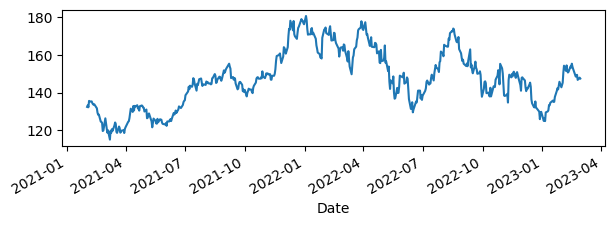

In [7]:
plt.rcParams["figure.figsize"] = (7,2)
plt.figure()
raw_aapl['Adj Close'].plot()

<Axes: xlabel='Date'>

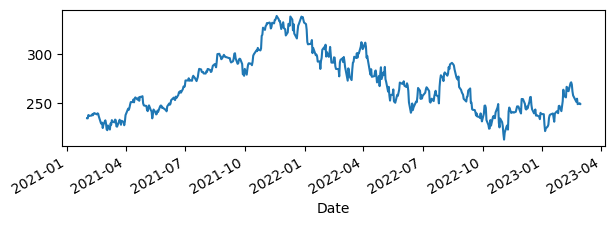

In [8]:
raw_msft['Adj Close'].plot()

<Axes: xlabel='Date'>

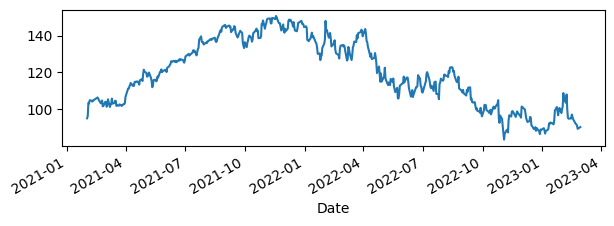

In [9]:
raw_goog['Adj Close'].plot()

<Axes: xlabel='Date'>

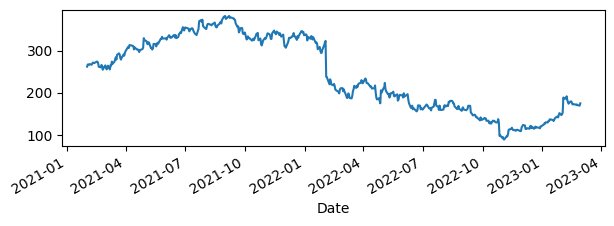

In [10]:
raw_meta['Adj Close'].plot()

<Axes: xlabel='Date'>

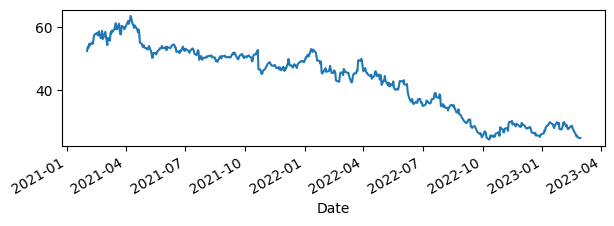

In [11]:
raw_intc['Adj Close'].plot()

<Axes: xlabel='Date'>

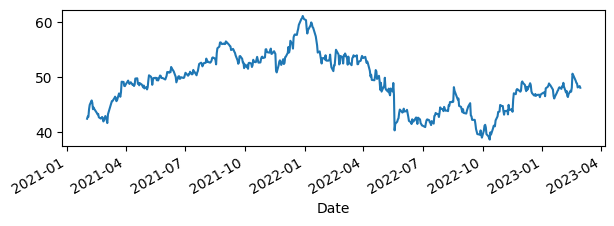

In [12]:
raw_csco['Adj Close'].plot()

<Axes: xlabel='Date'>

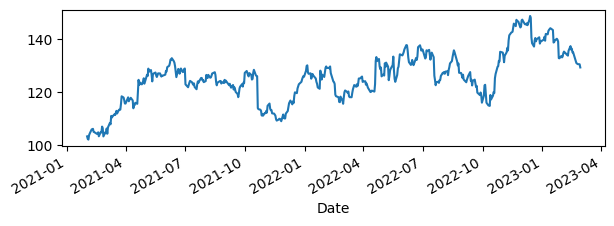

In [13]:
raw_ibm['Adj Close'].plot()

<Axes: xlabel='Date'>

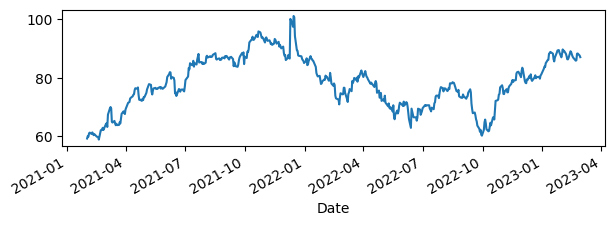

In [14]:
raw_orcl['Adj Close'].plot()

<Axes: xlabel='Date'>

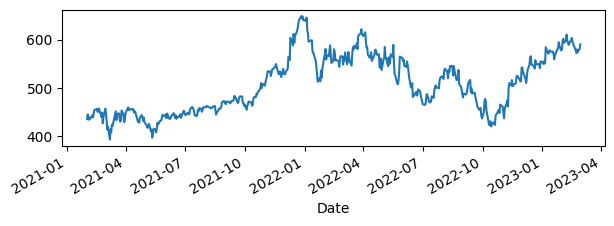

In [15]:
raw_avgo['Adj Close'].plot()

<Axes: xlabel='Date'>

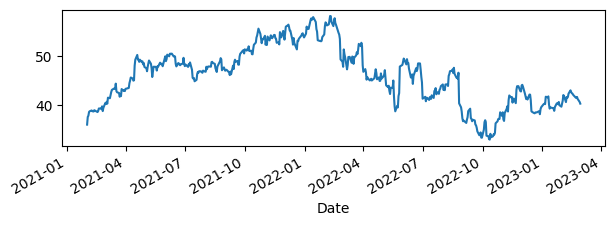

In [16]:
raw_dell['Adj Close'].plot()

In [17]:
# Calculate ROC, OBV, RSI from each company's raw dataset
# Again, we run this part on our local machine because talib doesn't fit the environment of google colab
def calculate_tech_indicator(raw):
  price_df = raw['Adj Close']
  volume_df = raw['Volume']
  rsi = talib.RSI(price_df)
  roc = talib.ROC(price_df)
  obv = talib.OBV(price_df, volume_df)
  processed_df = pd.concat([price_df, volume_df, rsi, roc, obv], axis=1)
  processed_df = processed_df.rename({'Adj Close': 'Price', 0: 'RSI', 1: 'ROC', 2: 'OBV'}, axis=1)
  return processed_df

In [18]:
# These are dataframe with ROC, RIS, and OBV
# 'Date' is dropped because the processed data is already ordered by date
# We run calculate_tech_indicator() to calculate them and upload the processed dataframe to github
raw_aapl = pd.read_csv('aapl.csv').drop(columns=['Date'])
raw_msft = pd.read_csv('msft.csv').drop(columns=['Date'])
raw_goog = pd.read_csv('goog.csv').drop(columns=['Date'])
raw_meta = pd.read_csv('meta.csv').drop(columns=['Date'])
raw_intc = pd.read_csv('intc.csv').drop(columns=['Date'])
raw_csco = pd.read_csv('csco.csv').drop(columns=['Date'])
raw_ibm  = pd.read_csv('ibm.csv').drop(columns=['Date'])
raw_orcl = pd.read_csv('orcl.csv').drop(columns=['Date'])
raw_avgo = pd.read_csv('avgo.csv').drop(columns=['Date'])
raw_dell = pd.read_csv('dell.csv').drop(columns=['Date'])

In [19]:
# Format traning samples by attching 11 days data into one row
# Lable each column by column name + date, so the columns look like Price1, Price2, OBV1, OBV2, ect
# return X,y where X includes training fetaures from the 1st to the 10th day, 
# y is the price on the 11th day that we want to predict

def clean_data(df,time_range):
  time_range+=1
  original_columns=df.columns.values.tolist()
  new_columns=[]
  label_name="Price"+ str(time_range)
  for day in range(1, time_range):
    for name in original_columns:
      new_columns.append(name+str(day))
  new_columns.append(label_name)

  new_data=[]
  for i in range(len(df)-time_range-1):
    new_row=[]
    for day in range(1,time_range):
      for name in original_columns:
        new_row.append(df.iloc[i+day][name])

    new_row.append(df.iloc[i+time_range]["Price"])
    new_data.append(new_row)
  new_df = pd.DataFrame(new_data,columns = [new_columns])
  new_df=new_df.dropna()
  
  y=new_df[label_name]
  X= new_df.sort_index(axis=1).drop(columns=[label_name])
  return X,y


In [20]:
from itertools import combinations

# Get a list of all 16 different feature combinations
def get_feature_combinations():
  additional_factors=['Volume', 'RSI', 'ROC', 'OBV']
  all_combination=[]
  for i in range(1,len(additional_factors)):
    combs = combinations(additional_factors,i)
    for comb in combs:
      all_combination.append(list(comb)+['Price'])
  
  all_combination=[['Price']]+all_combination+[['Volume', 'RSI', 'ROC', 'OBV','Price']]
  return all_combination
get_feature_combinations()

[['Price'],
 ['Volume', 'Price'],
 ['RSI', 'Price'],
 ['ROC', 'Price'],
 ['OBV', 'Price'],
 ['Volume', 'RSI', 'Price'],
 ['Volume', 'ROC', 'Price'],
 ['Volume', 'OBV', 'Price'],
 ['RSI', 'ROC', 'Price'],
 ['RSI', 'OBV', 'Price'],
 ['ROC', 'OBV', 'Price'],
 ['Volume', 'RSI', 'ROC', 'Price'],
 ['Volume', 'RSI', 'OBV', 'Price'],
 ['Volume', 'ROC', 'OBV', 'Price'],
 ['RSI', 'ROC', 'OBV', 'Price'],
 ['Volume', 'RSI', 'ROC', 'OBV', 'Price']]

In [ ]:
# Calculate MSE for each feature combination
def test_all_lr(processed_df):
  all_rmse=[]
  all_combinations= get_feature_combinations()

  #loop through all feature combinations
  for comb in all_combinations:
    cur_df=processed_df[comb]
    X,y=clean_data(cur_df,10)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #standardize data so the model won't be affected by huge ranges and huge variances of some features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)  

    # Add a column of ones to the feature matrices to record bias
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    #train linear regression model
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    rmse=mean_squared_error(y_test, y_pred,squared=False)
    all_rmse.append([comb,rmse])
  all_rmse=sorted(all_rmse, key=lambda x: x[1])  
  print(*all_rmse,sep = "\n")
  return all_rmse


In [ ]:
all_rmse_lr=[]
print("aapl")
aapl_rmse_lr=test_all_lr(raw_aapl)
all_rmse_lr.append(aapl_rmse_lr)
print("")

print("msft")
msft_rmse_lr=test_all_lr(raw_msft)
all_rmse_lr.append(msft_rmse_lr)
print("")

print("goog")
goog_rmse_lr=test_all_lr(raw_goog)
all_rmse_lr.append(goog_rmse_lr)
print("")

print("meta")
meta_rmse_lr=test_all_lr(raw_meta)
all_rmse_lr.append(meta_rmse_lr)
print("")

print("intc")
intc_rmse_lr=test_all_lr(raw_intc)
all_rmse_lr.append(intc_rmse_lr)
print("")

print("ibm")
ibm_rmse_lr=test_all_lr(raw_ibm)
all_rmse_lr.append(ibm_rmse_lr)
print("")

print("csco")
csco_rmse_lr=test_all_lr(raw_csco)
all_rmse_lr.append(csco_rmse_lr)
print("")

print("orcl")
orcl_rmse_lr=test_all_lr(raw_orcl)
all_rmse_lr.append(orcl_rmse_lr)
print("")

print("avgo")
avgo_rmse_lr=test_all_lr(raw_avgo)
all_rmse_lr.append(avgo_rmse_lr)
print("")

print("dell")
dell_rmse_lr=test_all_lr(raw_dell)
all_rmse_lr.append(dell_rmse_lr)

aapl
[['RSI', 'Price'], 3.0031483280640283]
[['Price'], 3.006828198490285]
[['OBV', 'Price'], 3.035327020452566]
[['Volume', 'RSI', 'OBV', 'Price'], 3.0401371832848922]
[['Volume', 'Price'], 3.0446342548318053]
[['Volume', 'OBV', 'Price'], 3.049528426442892]
[['ROC', 'Price'], 3.1525016729620257]
[['Volume', 'RSI', 'ROC', 'Price'], 3.1863525724464594]
[['ROC', 'OBV', 'Price'], 3.2002712092498227]
[['Volume', 'ROC', 'Price'], 3.2011504715902652]
[['Volume', 'RSI', 'ROC', 'OBV', 'Price'], 3.222053520037262]
[['Volume', 'ROC', 'OBV', 'Price'], 3.225018112813235]
[['RSI', 'ROC', 'Price'], 3.4903823844274924]
[['Volume', 'RSI', 'Price'], 3.530866839031864]
[['RSI', 'ROC', 'OBV', 'Price'], 4.06835811221491]
[['RSI', 'OBV', 'Price'], 6.129396388124699]

msft
[['RSI', 'Price'], 5.312944483007946]
[['Price'], 5.3249545783207335]
[['RSI', 'OBV', 'Price'], 5.350369417005524]
[['OBV', 'Price'], 5.381980940640176]
[['Volume', 'RSI', 'Price'], 5.486210751920653]
[['Volume', 'Price'], 5.4972935337957

In [ ]:
from collections import defaultdict
from statistics import mean
companies=['aapl','msft','goog','meta','intc','ibm','csco','orcl','avgo','dell']

#Calculate average rank for each feature combination
def cal_avg_rank(all_rmse):
  rank=defaultdict(list)
  for company_rmse_rank in all_rmse:
    for i in range(len(company_rmse_rank)):
      combination_name=','.join(company_rmse_rank[i][0])
      rank[combination_name].append(i+1)
  avg_rank=defaultdict(int)
  for combination in rank:
    avg_rank[combination]=mean(rank[combination])
    
  avg_rank=sorted(avg_rank.items(), key=lambda x:x[1])
  for rank in avg_rank:
    print(rank)
  return avg_rank

avg_rank_lr= cal_avg_rank(all_rmse_lr)

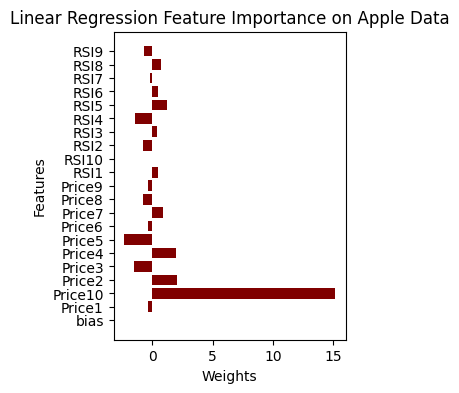

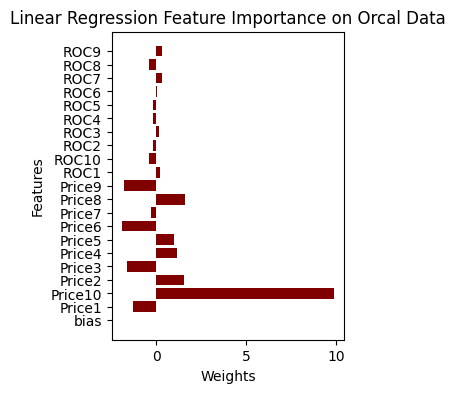

In [ ]:
# Train linear model on Apple data with its best feature combination
best_appl_df=raw_aapl[['Price','RSI']]
X,y=clean_data(best_appl_df,10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
best_aapl_model = LinearRegression().fit(X_train, y_train)

# Plot feature importance graph
features=['bias']+list([x[0] for x in X.columns.values])
plt.figure(figsize=(3,4))
plt.barh(features, best_aapl_model.coef_[0], color ='maroon')
plt.xlabel("Weights")
plt.ylabel("Features")
plt.title("Linear Regression Feature Importance on Apple Data")
plt.show()

# Train linear model on Orcal data with its best feature combination
best_orcl_df=raw_orcl[['Price','ROC']]
X,y=clean_data(best_orcl_df,10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
best_orcl_model = LinearRegression().fit(X_train, y_train)

# Plot feature importance graph
features=['bias']+list([x[0] for x in X.columns.values])
plt.figure(figsize=(3,4))
plt.barh(features, best_orcl_model.coef_[0], color ='maroon')
plt.xlabel("Weights")
plt.ylabel("Features")
plt.title("Linear Regression Feature Importance on Orcal Data")
plt.show()


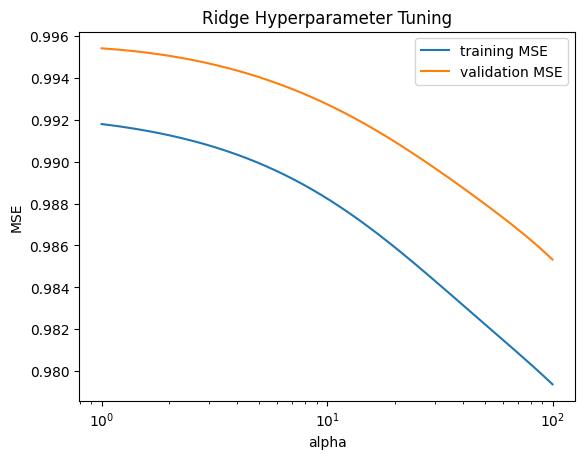

In [ ]:
#parameter tuning 
best_meta_df=raw_meta[['Price']]
X,y=clean_data(best_meta_df,10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

from math import log2
alphas = np.arange(1.0, 100.0, 0.1)
r2_train=[]
r2_val=[]
for a in alphas:
  model=Ridge(alpha=a)
  model.fit(X_train2,y_train2)
  pred_y_train_cur=model.predict(X_train2)
  r2_train_cur=r2_score(y_train2, pred_y_train_cur)
  r2_train.append(r2_train_cur)

  pred_y_val_cur=model.predict(X_val)
  r2_val_cur=r2_score(y_val, pred_y_val_cur)
  r2_val.append(r2_val_cur)

plt.plot(alphas, r2_train, label = "training MSE")
plt.plot(alphas, r2_val, label = "validation MSE")
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.xscale("log")
plt.title("Ridge Hyperparameter Tuning")
plt.legend()
plt.show()

In [ ]:
best_alpha_index_ls=np.argmax(r2_val)
best_alpha=alphas[best_alpha_index_ls]
print("best alpha",best_alpha)
best_ridge_model=Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train,y_train)
print(best_ridge_model.intercept_, best_ridge_model.coef_, best_ridge_model.score(X_test,y_test))

best alpha 1.0
[241.94551669] [[ 0.          0.20748543 62.03206506  4.3423466   0.67291156 -2.9592746
   3.30528636  1.46324665 -3.06993245  1.46747149 20.82007941]] 0.9933852531497076


# Decision Tree

In [21]:
from matplotlib.ticker import MaxNLocator
# Build Decision Tree and Prune the tree
all_dt_combinations=[]

def dt_pruning(processed_df):
  all_rmse=[]
  X,y=clean_data(processed_df,10)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  
  # Fit the Decision Tree with all features and obtain the max depth
  dt_max = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)
  all_depth=[int(i) for i in range(1,dt_max.tree_.max_depth+1)]

  #Prune the tree and record MSE
  for cur_depth in all_depth:
    reg = DecisionTreeRegressor(random_state=0,max_depth = cur_depth).fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    rmse=mean_squared_error(y_test, y_pred,squared=False)
    all_rmse.append(rmse)
  
  #Plot Pruning MSE
  #plt.figure(figsize=(3,2))
  #plt.plot(all_depth, all_rmse)
  #plt.xlabel('Decision Tree Depth')
  #plt.ylabel('MSE')
  #plt.show()

  # Get tree depth with the smallest MSE and plot the tree
  fn=[x[0] for x in list(X.columns)]
  best_depth=np.argmin(all_rmse)
  print("best_depth:", best_depth)
  best_tree=DecisionTreeRegressor(random_state=0,max_depth = best_depth).fit(X_train, y_train)
  plt.figure(figsize=(12,12))
  tree.plot_tree(best_tree,fontsize=10,feature_names=fn)

  #record feature combiantion
  feature_comb=dt_feature_importance(best_tree,fn)
  all_dt_combinations.append(feature_comb)

  return best_tree

In [22]:
# Plot Decision Tree feature_importance
def dt_feature_importance(best_model,feature_names):
  feat_imps=zip(feature_names,best_model.feature_importances_)
  feat,imps=zip(*(sorted(list(filter(lambda x:x[1]!=0, feat_imps)),key=lambda x:x[1])))

  #Get feature importance graph
  plt.figure(figsize=(3,5))
  plt.barh(feat, imps)
  plt.xlabel("Feature Importance")
  plt.ylabel("Features")
  plt.title("Feature Importance of Decision Tree")
  plt.yticks(fontsize=7)
  plt.show()

  processed_comb = set()
  for feature in feat:
    feat=re.sub(r'[0-9]', '', feature)
    processed_comb.add(feat)
  comb = list(processed_comb)
  comb.sort()
  print("feature combination:",comb)
  return comb


aapl
best_depth: 3


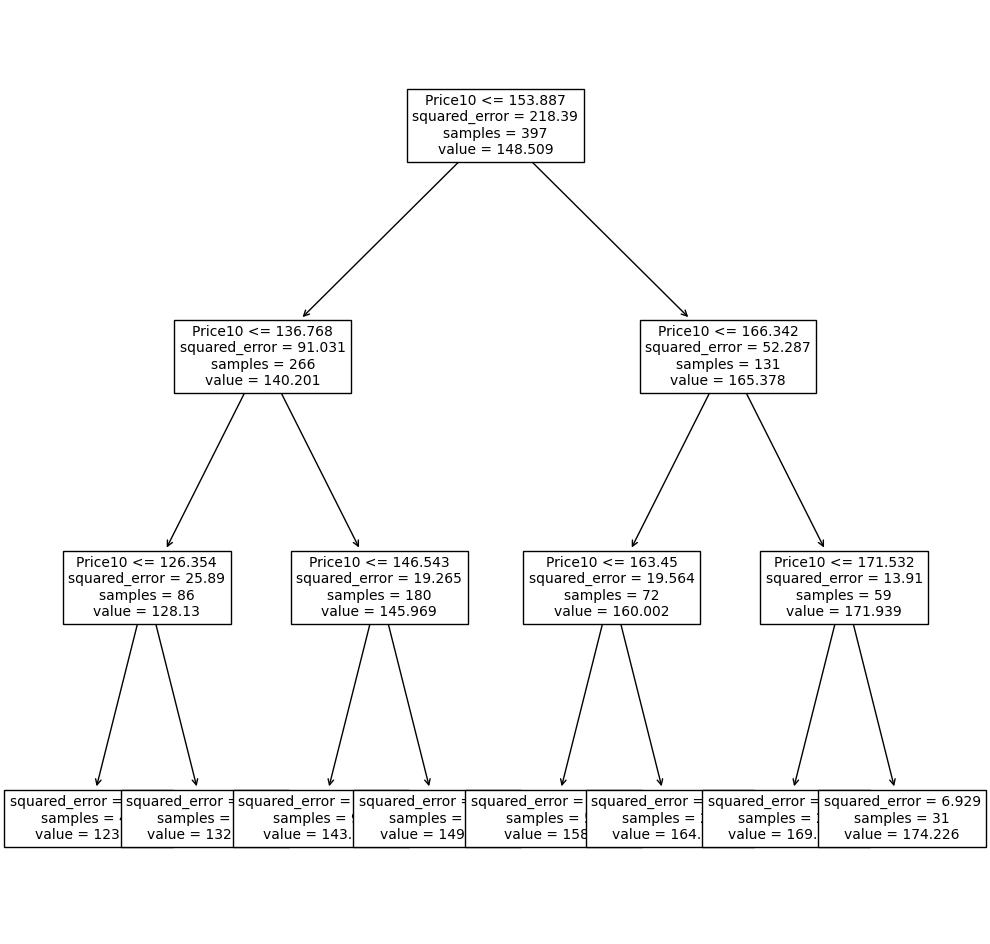

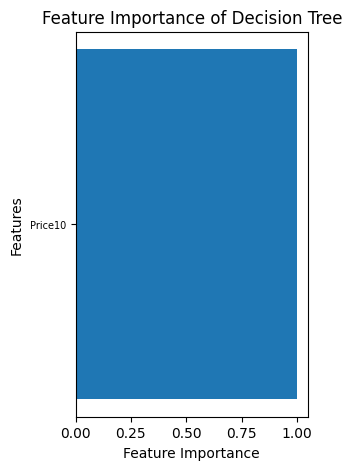

feature combination: ['Price']

msft
best_depth: 2


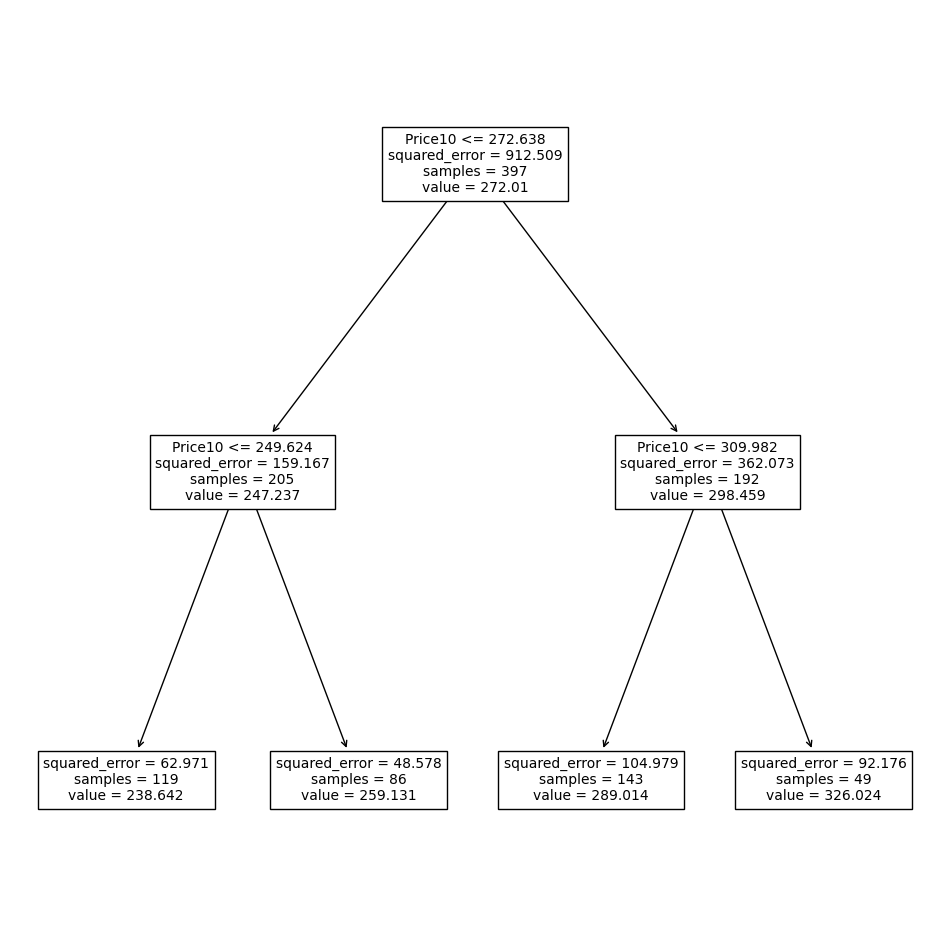

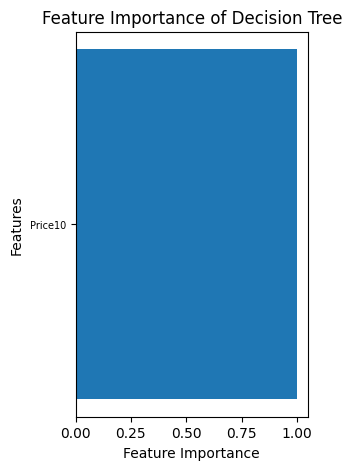

feature combination: ['Price']

goog
best_depth: 5


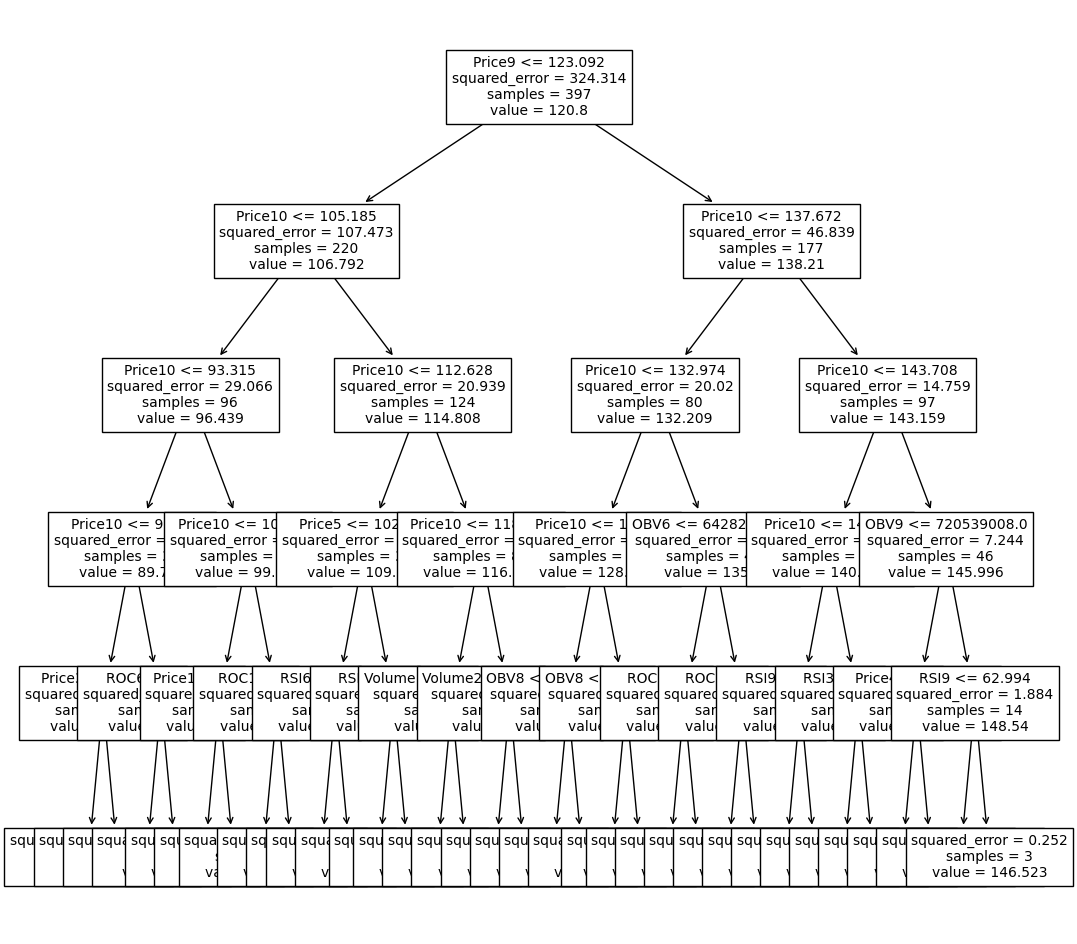

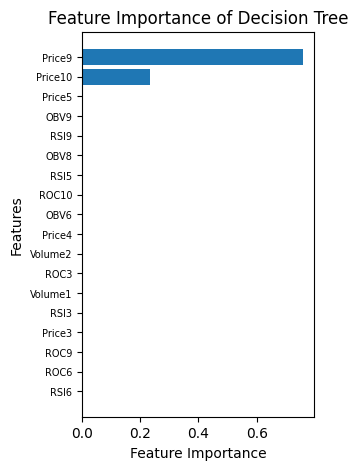

feature combination: ['OBV', 'Price', 'ROC', 'RSI', 'Volume']
 
meta
best_depth: 4


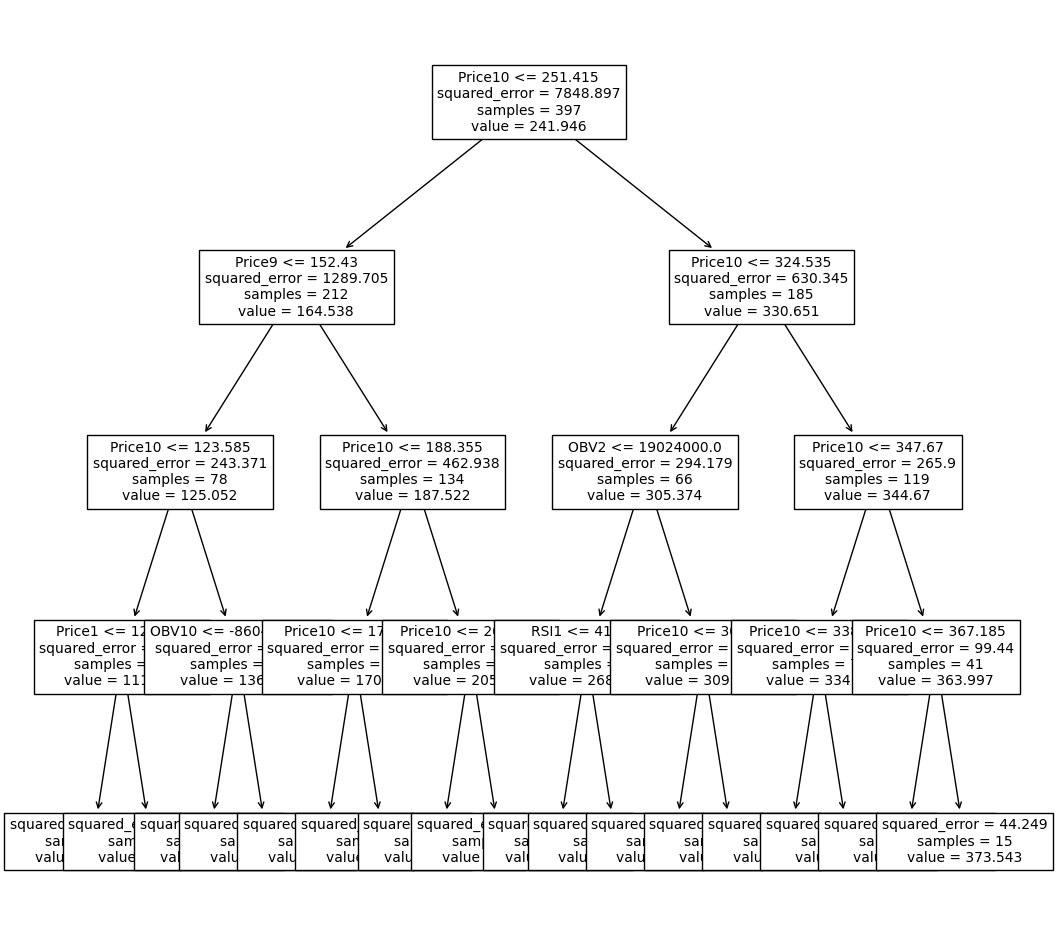

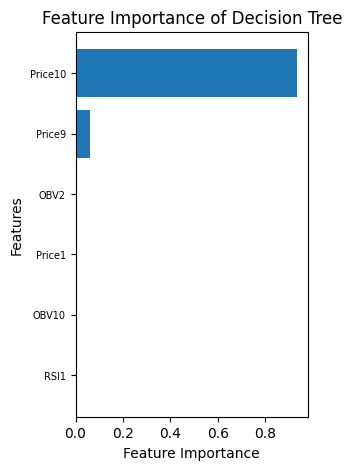

feature combination: ['OBV', 'Price', 'RSI']

intc
best_depth: 12


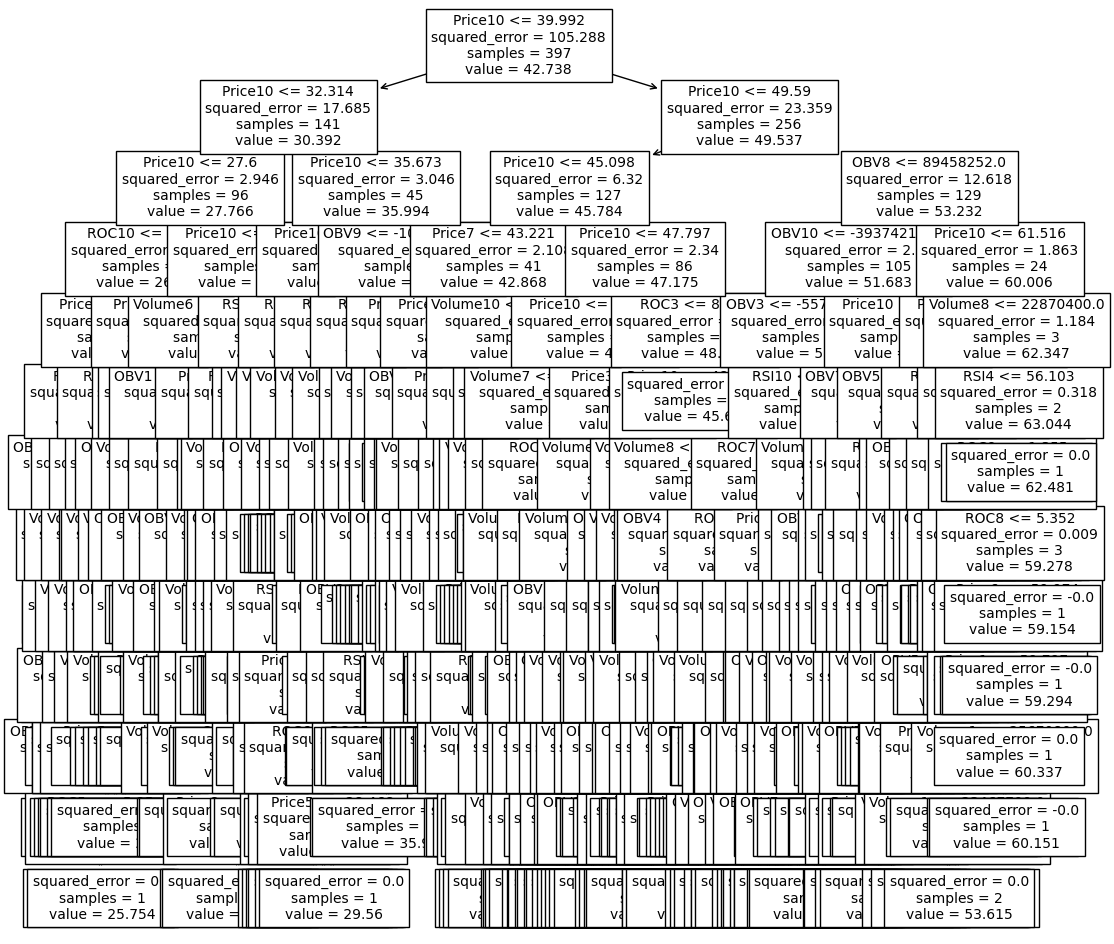

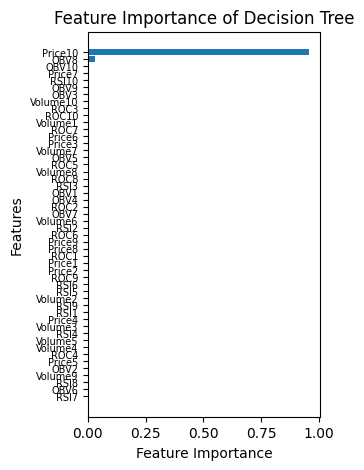

feature combination: ['OBV', 'Price', 'ROC', 'RSI', 'Volume']

ibm
best_depth: 3


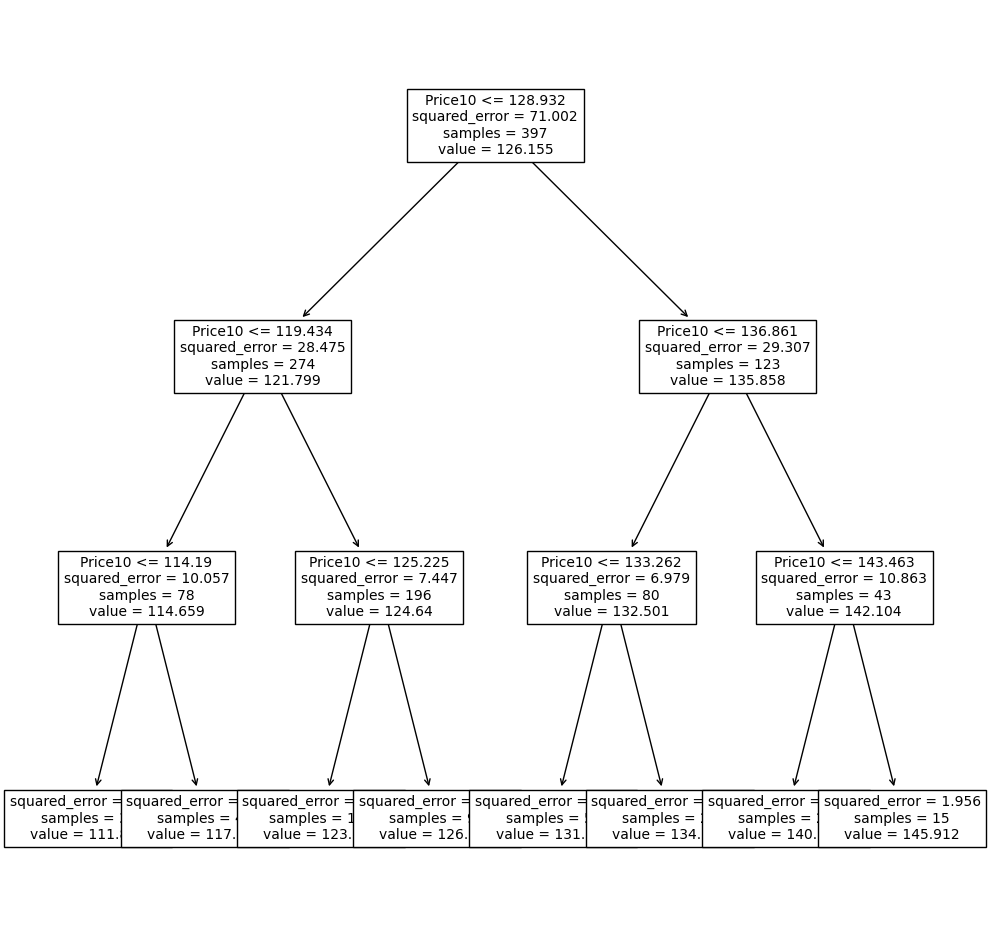

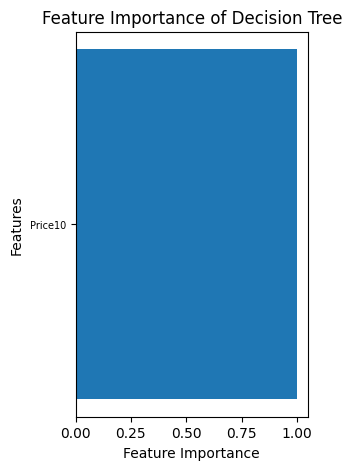

feature combination: ['Price']

csco
best_depth: 3


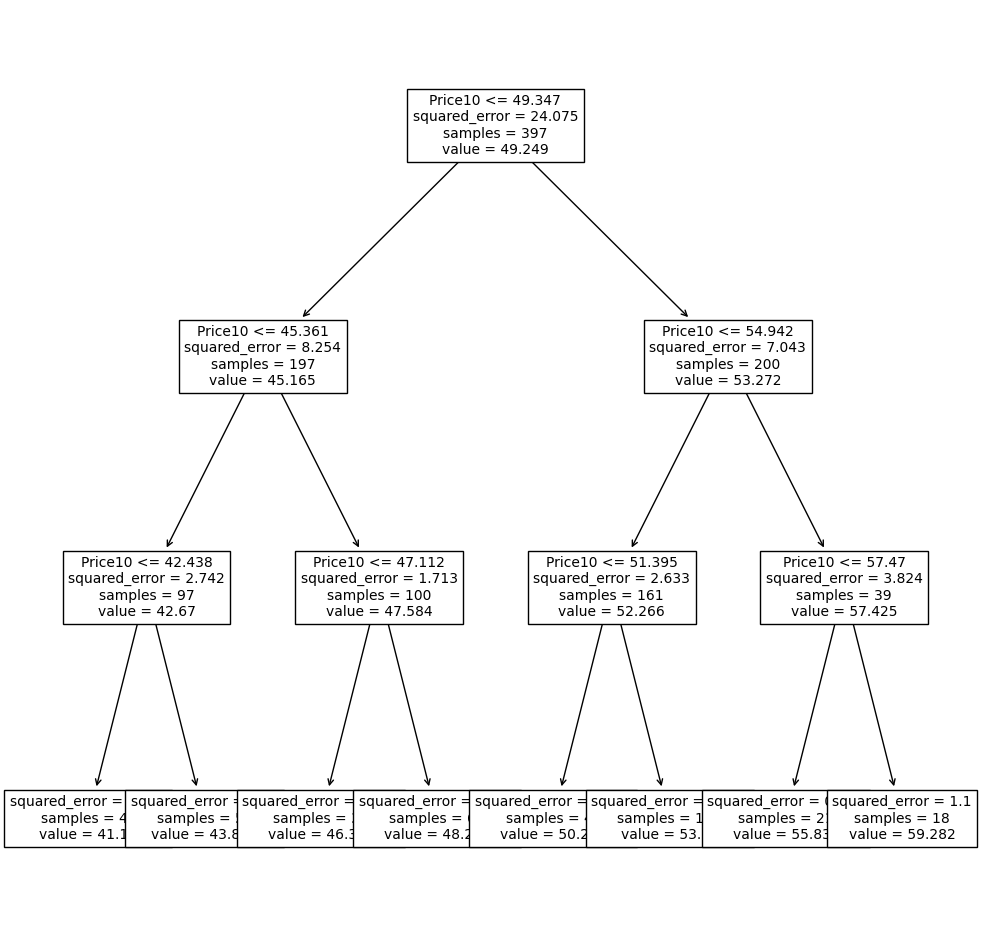

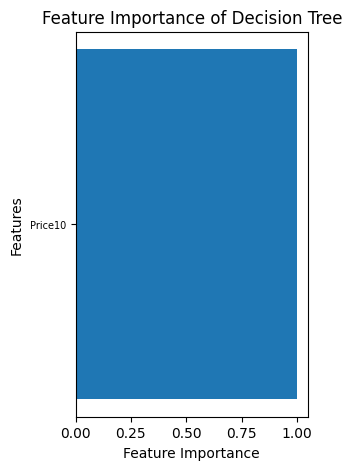

feature combination: ['Price']

orcl
best_depth: 4


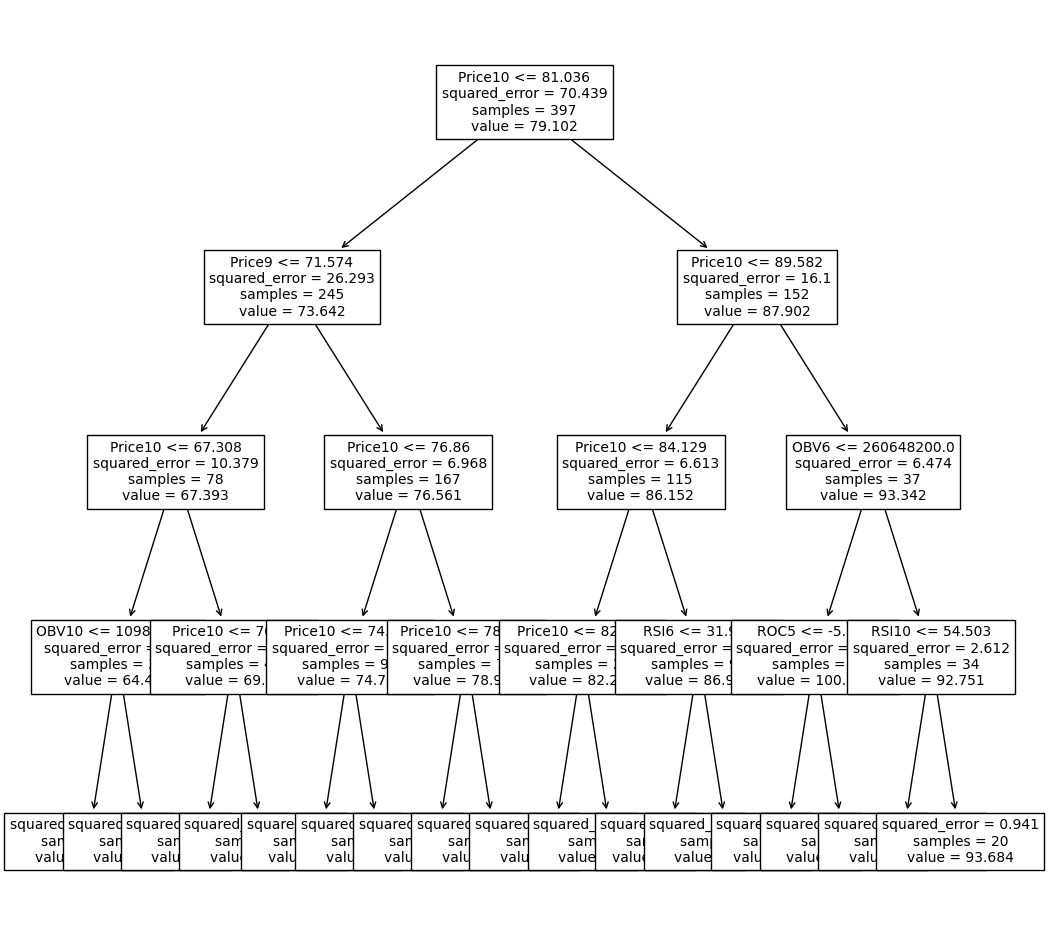

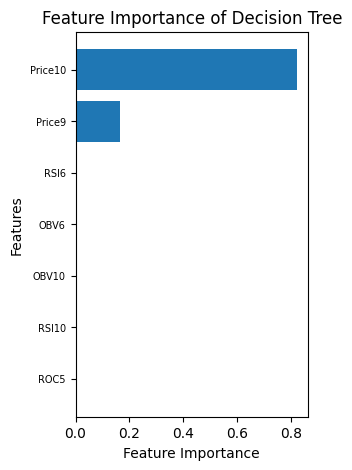

feature combination: ['OBV', 'Price', 'ROC', 'RSI']

avgo
best_depth: 3


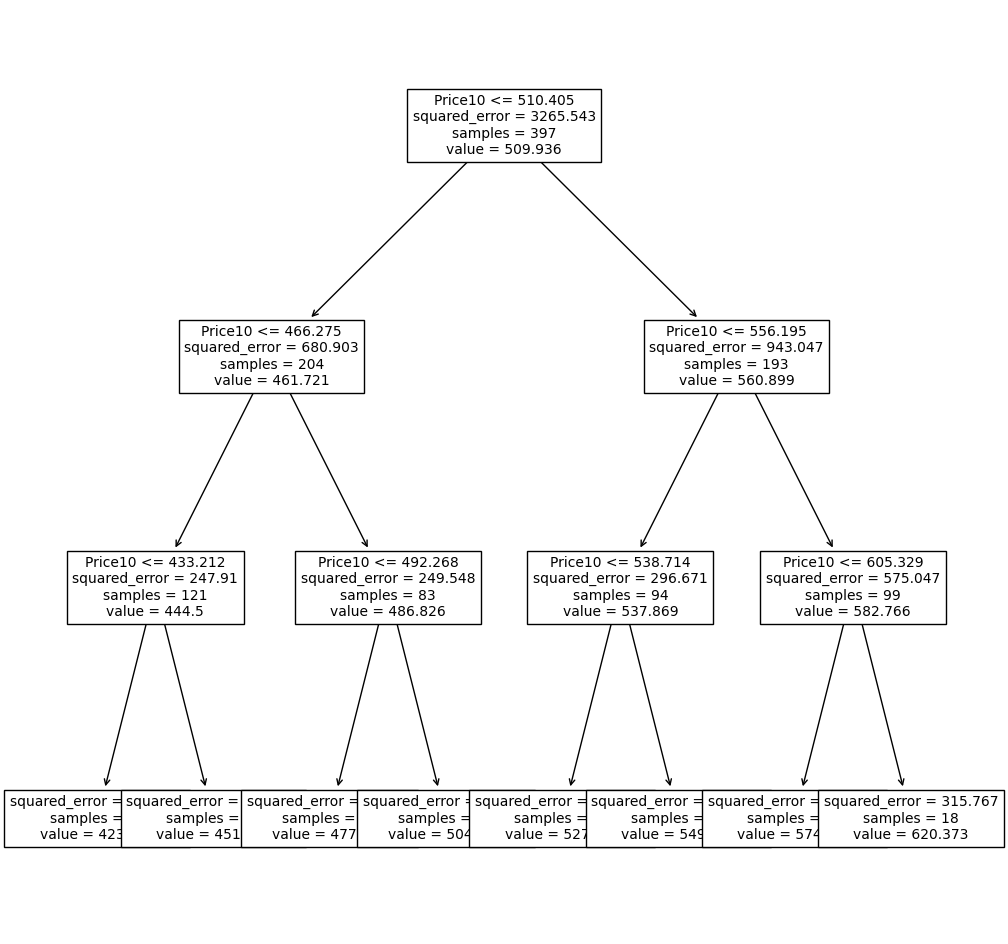

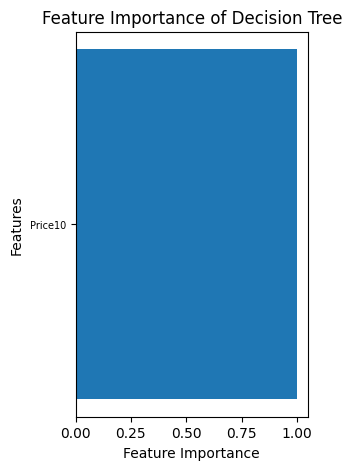

feature combination: ['Price']

dell
best_depth: 4


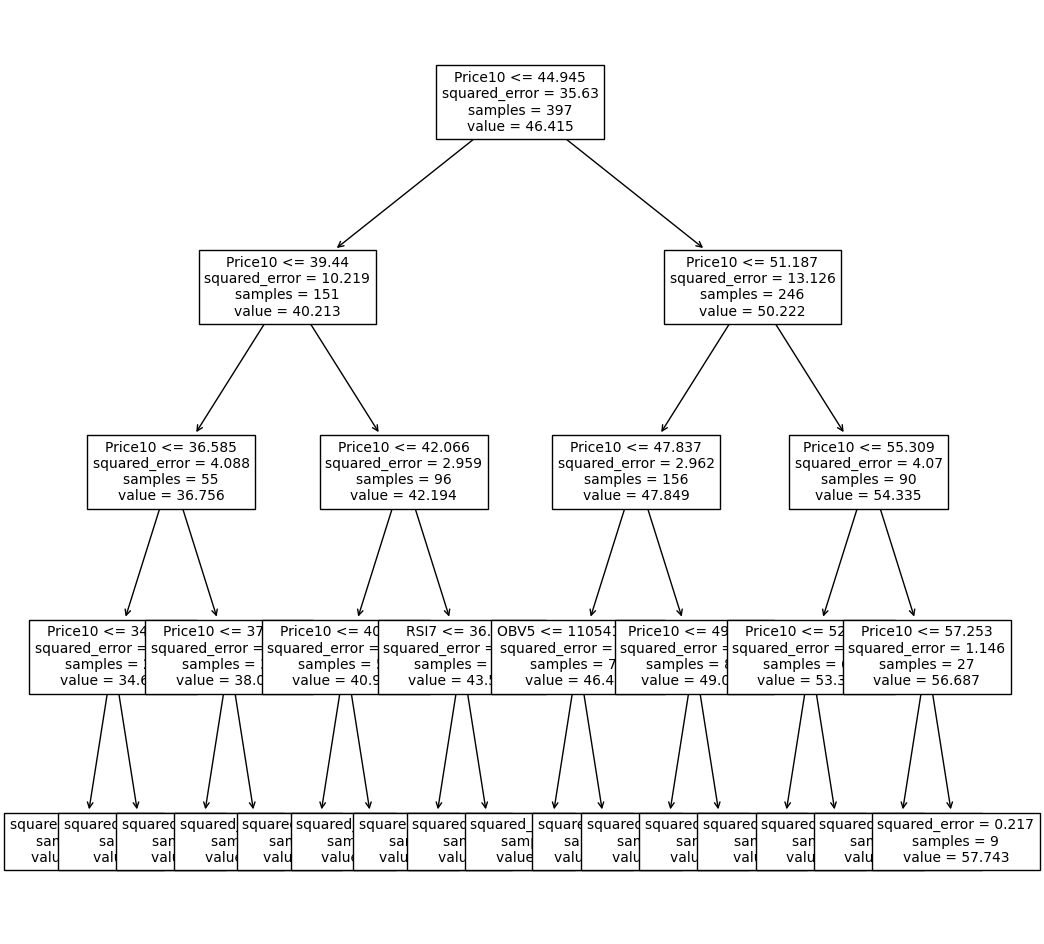

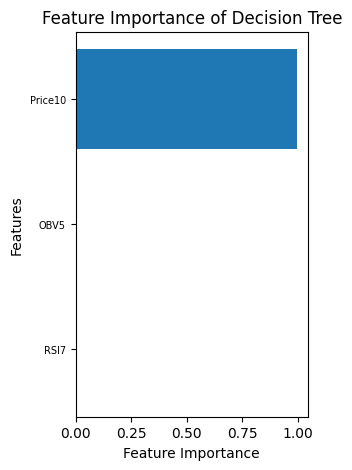

feature combination: ['OBV', 'Price', 'RSI']


In [23]:
print("aapl")
aapl_dt=dt_pruning(raw_aapl)
print("")

print("msft")
msft_dt=dt_pruning(raw_msft)
print("")

print("goog")
goog_dt=dt_pruning(raw_goog)
print(" ")

print("meta")
meta_dt=dt_pruning(raw_meta)
print("")

print("intc")
intc_dt=dt_pruning(raw_intc)
print("")

print("ibm")
ibm_dt=dt_pruning(raw_ibm)
print("")

print("csco")
csco_dt=dt_pruning(raw_csco)
print("")

print("orcl")
orcl_dt=dt_pruning(raw_orcl)
print("")

print("avgo")
avgo_dt=dt_pruning(raw_avgo)
print("")

print("dell")
dell_dt=dt_pruning(raw_dell)

In [24]:
#get feature combination rank
all_dt_combinations=sorted(all_dt_combinations, key=len )
all_dt_combinations

[['Price'],
 ['Price'],
 ['Price'],
 ['Price'],
 ['Price'],
 ['OBV', 'Price', 'RSI'],
 ['OBV', 'Price', 'RSI'],
 ['OBV', 'Price', 'ROC', 'RSI'],
 ['OBV', 'Price', 'ROC', 'RSI', 'Volume'],
 ['OBV', 'Price', 'ROC', 'RSI', 'Volume']]

### Neural Network

In [ ]:
def test_all_nn(processed_df):
  all_rmse=[]
  all_combinations=get_feature_combinations()

  for comb in all_combinations:
    cur_df=processed_df[comb]
    X,y=clean_data(cur_df,10)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = tf.keras.Sequential() 
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    model.compile(optimizer="Adam", loss="mse")

    history = model.fit(X_train, y_train, epochs=100, verbose=0)

    # print(model.score(X_train, y_train))

    y_pred = model.predict(X_test, verbose=0)
    rmse=mean_squared_error(y_test, y_pred,squared=False)
    all_rmse.append([comb,rmse])
  all_rmse=sorted(all_rmse, key=lambda x: x[1])
  print(*all_rmse,sep = "\n")
  return all_rmse

In [ ]:
all_rmse_nn=[]
print("aapl")
aapl_rmse_nn=test_all_nn(raw_aapl)
all_rmse_nn.append(aapl_rmse_nn)
print("")

print("msft")
msft_rmse_nn=test_all_nn(raw_msft)
all_rmse_nn.append(msft_rmse_nn)
print("")

print("goog")
goog_rmse_nn=test_all_nn(raw_goog)
all_rmse_nn.append(goog_rmse_nn)
print("")

print("meta")
meta_rmse_nn=test_all_nn(raw_meta)
all_rmse_nn.append(meta_rmse_nn)
print("")

print("intc")
intc_rmse_nn=test_all_nn(raw_intc)
all_rmse_nn.append(intc_rmse_nn)
print("")

print("ibm")
ibm_rmse_nn=test_all_nn(raw_ibm)
all_rmse_nn.append(ibm_rmse_nn)
print("")

print("csco")
csco_rmse_nn=test_all_nn(raw_csco)
all_rmse_nn.append(csco_rmse_nn)
print("")

print("orcl")
orcl_rmse_nn=test_all_nn(raw_orcl)
all_rmse_nn.append(orcl_rmse_nn)
print("")

print("avgo")
avgo_rmse_nn=test_all_nn(raw_avgo)
all_rmse_nn.append(avgo_rmse_nn)

print("dell")
dell_rmse_nn=test_all_nn(raw_dell)
all_rmse_nn.append(avgo_rmse_nn)

aapl
[['ROC', 'Price'], 3.125230912455649]
[['RSI', 'Price'], 5.6001723862233765]
[['Price'], 147.31400163149527]
[['Volume', 'Price'], 147.31400163149527]
[['OBV', 'Price'], 147.31400163149527]
[['Volume', 'RSI', 'Price'], 147.31400163149527]
[['Volume', 'OBV', 'Price'], 147.31400163149527]
[['RSI', 'ROC', 'Price'], 147.31400163149527]
[['RSI', 'OBV', 'Price'], 147.31400163149527]
[['Volume', 'RSI', 'ROC', 'Price'], 147.31400163149527]
[['Volume', 'ROC', 'OBV', 'Price'], 147.31400163149527]
[['RSI', 'ROC', 'OBV', 'Price'], 147.31400163149527]
[['Volume', 'RSI', 'ROC', 'OBV', 'Price'], 147.31400163149527]
[['Volume', 'ROC', 'Price'], 1620.5975247375197]
[['Volume', 'RSI', 'OBV', 'Price'], 231977.1589539962]
[['ROC', 'OBV', 'Price'], 1272941.8793831468]

msft
[['RSI', 'ROC', 'Price'], 6.756184662720155]
[['Price'], 270.5649420117145]
[['Volume', 'Price'], 270.5649420117145]
[['RSI', 'Price'], 270.5649420117145]
[['ROC', 'Price'], 270.5649420117145]
[['Volume', 'RSI', 'Price'], 270.56494

In [ ]:
# sorted_rmse_nn = []
# for p in all_rmse_nn:
#   sorted_rmse_nn.append(sorted(p, key=lambda x: x[1]))

avg_rank_nn= cal_avg_rank(all_rmse_nn)

('Price', 2.6)
('ROC,Price', 2.9)
('RSI,Price', 3)
('RSI,ROC,Price', 3.4)
('Volume,Price', 5.6)
('Volume,RSI,Price', 6.6)
('OBV,Price', 7.7)
('Volume,OBV,Price', 9.2)
('Volume,RSI,ROC,Price', 9.7)
('RSI,OBV,Price', 9.8)
('Volume,ROC,Price', 10.5)
('Volume,ROC,OBV,Price', 12.6)
('RSI,ROC,OBV,Price', 12.8)
('ROC,OBV,Price', 12.9)
('Volume,RSI,ROC,OBV,Price', 13.3)
('Volume,RSI,OBV,Price', 13.4)
